In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.collections import PathCollection
import geopandas as gpd
import pandas as pd
import numpy as np
import gzip
import pickle
import copy

plt.show()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict    
#
#
def pickle_out(gRNA_dict,outfile):
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(gRNA_dict, f)
    f.close()
#
#
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
#
def strain_mini(combined):
    strain_mini_sets={strain: [idx for idx in combined.loc[strain][~(combined.loc[strain].isna())].index if 'Tb_mO' in idx] for strain in combined.index}
    return(strain_mini_sets)
##modify the first step for data input
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    #metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)

#in how many strains is each gf present

In [4]:
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
def strain_minis(csv):
    df=pd.read_csv(csv,index_col='renamed') #set a new index
    mini_dict={strain:set(df.loc[strain][~(df.loc[strain].isna())].index) for strain in df.index}
    return(mini_dict)

def assign_gRNA(df,gRNA_dict):
    strain_mrna={}
    v1_unique=['ND8_v1-402_407','ND8_v1-542_546','A6_v1-799_801']
    for strain in df.index:
        empty_mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
        minis=set(df.loc[strain][~(df.loc[strain].isna())].index)
        strain_mrna[strain]=empty_mRNA_dict
        for key in gRNA_dict:
            if gRNA_dict[key]['mO_name'] in minis:
                x1=int(gRNA_dict[key]['mRNA_start'])
                x2=int(gRNA_dict[key]['mRNA_end'])
                x3=int(gRNA_dict[key].get('anchor_len',6))
                strain_mrna[strain][gRNA_dict[key]['mRNA_name']].append((x1,x2,x3))
                mrna=gRNA_dict[key]['mRNA_name']
                if 'v1' in mrna and gRNA_dict[key]['gRNA_family'][0] not in v1_unique:
                    mrna=mrna.replace('v1','v2')
                    strain_mrna[strain][mrna].append((x1,x2,x3))
                #print(len(strain_mrna[strain][gRNA_dict[key]['mRNA_name']]),strain,gRNA_dict[key]['mRNA_name'])
    return(strain_mrna)

def get_gRNA_info (txt,csv=False,matches=False):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{index}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for index,line in enumerate(handle)}
        mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
        for key in gRNA_dict:
            x1=int(gRNA_dict[key]['mRNA_start'])
            x2=int(gRNA_dict[key]['mRNA_end'])
            x3=int(gRNA_dict[key].get('anchor_len',6))
            mRNA_dict[gRNA_dict[key]['mRNA_name']].append((x1,x2,x3))
        if matches != False:
            #matches='/home/jovyan/minicircle_annotation/Tbg1_cleaned_minicircles.log'
            match_dict={list(filter(None,l.strip('\n').split(' ')))[1]:list(filter(None,l.strip('\n').split(' ')))[0] for l in open(matches)} #translate mini naming system
            print(match_dict)
            for k in gRNA_dict:
                gRNA_dict[k]['mO_name']=match_dict[gRNA_dict[k]['mO_name']]
    #assign minicircle/gRNAs to each strain (using old copy number analysis)
    def assign_gRNA(csv,gRNA_dict):
        df=pd.read_csv(csv,index_col='renamed') #set a new index
        strain_mrna={}
        for strain in df.index:
            empty_mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
            minis=set(df.loc[strain][~(df.loc[strain].isna())].index)
            strain_mrna[strain]=empty_mRNA_dict
            for key in gRNA_dict:
                if gRNA_dict[key]['mO_name'] in minis:
                    x1=int(gRNA_dict[key]['mRNA_start'])
                    x2=int(gRNA_dict[key]['mRNA_end'])
                    x3=int(gRNA_dict[key].get('anchor_len',6))
                    strain_mrna[strain][gRNA_dict[key]['mRNA_name']].append((x1,x2,x3))
                    #print(len(strain_mrna[strain][gRNA_dict[key]['mRNA_name']]),strain,gRNA_dict[key]['mRNA_name'])
        return(strain_mrna)
    if csv!=False:
        strain_mrna=assign_gRNA(csv,gRNA_dict)
        return(strain_mrna,gRNA_dict) 
    else:
        return(mRNA_dict,gRNA_dict)

def find_gap2(dictionary,insertions,key): #mrna_dict
    gaps,edits=[],copy.deepcopy(insertions[key])
    for i in sorted(dictionary[key]):
        for site in range(i[0],i[1]-6):
            edits[site]+=1
    x=[i for i,j in enumerate(edits) if j ==0]
    return(x)

def draw_grna(coor,adj=0,y=0.5,color='blue'):
    xstart=int(coor[0])-adj
    xend=int(coor[1])-adj
    anchor_len=int(coor[2])
    hl=(xend-xstart)/10
    plt.arrow(xend,y,-anchor_len,0,head_width=0, head_length=0, width=0.2,fc='red', ec='None',alpha=0.5) #draw anchor
    plt.arrow(xend-anchor_len,y,(xstart-xend+anchor_len+hl),0,head_width=0.2, head_length=hl, width=0.2,fc=color, ec=color,alpha=0.5)
    #plt.vlines(xstart,1,y,colors='k',linestyles='dashed',alpha=0.4)

def plot_alignment(dictionary,key,y=1,adj=0,arrowcolor='skyblue',up=False,fold=3):
    yheight,count,y0,reached_min=len(dictionary[key])/fold,0,y,0
    for coor in sorted(dictionary[key],key=lambda x:x[1]):
        draw_grna(coor,adj,y=y,color=arrowcolor)
        count+=1
        if up == False:
            y-=0.2
        else:
            y+=0.2
        if count >= yheight:
            ymin=y
            y=y0
            count=0
            reached_min=1
    if reached_min==0:
        ymin=y
    return(ymin)
    
def gRNA_depth(mRNA,mrna_dict,key):
    total=np.array([0]*len(mRNA))
    for pair in mrna_dict[key]:
        total+=np.array([0]*(pair[0]-1)+[1]*(pair[1]-pair[0]-8+1)+[0]*(len(mRNA)-pair[1]+8)) #-8 instead -pair[2]
    return(total)

def plot_mRNA_gRNA(strain_mrna,combined,key,Outdir,lw=4, #mRNA-dicts+strain--> strain_mrna
                   y=0.1,adj=0,arrowcolor='black',up=False,fold=3,figw=20,figh=10,output='mRNA_coverage'): #with dots
    #
    insertions=read_editing_sites(small_u)
    insertions['A6']=insertions['A6_v1']
    deletion=read_deletion_sites(dels)
    deletion['A6']=deletion['A6_v1']
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))   
    axs.axis('off')
    start=-0.3
    ymin=0
    #label numbers for mRNA length
    for i in range(0,len(insertions[key]),50):
        axs.text(i,ymin,f"{i}",fontsize=20)
    ymin-=0.5
    #draw insertion sites: 0 for insertions
    x=[i for i,c in enumerate(insertions[key]) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='purple',linewidth=5)
    ymin-=1
    #draw deletions
    x=[i for i,c in enumerate(deletion[key]) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='red',linewidth=5)
    ymin+=-1
    #find the last editing site
    last1,last2=0,0
    for i,b in enumerate(deletion[key]):
        if b=='0':
            last1=i
    for i,b in enumerate(insertions[key]):
        if b=='0':
            last2=i
    last=max(last1,last2)
    #plot gRNA alignment
    gaps,gap_dict=[],{}
    for strain in strain_mrna:
        ymin-=2
        mRNA_dict=strain_mrna[strain]
        yprevious=ymin
        y=ymin
        ymin=plot_alignment(mRNA_dict,key,y,adj,arrowcolor,up,fold)
        axs.hlines(ymin,0,len(insertions[key]),colors='k',linestyles='dashed',alpha=0.4)
        if strain in combined.index:
            mininum=int(combined.loc[strain,'minicircle_classes'])
        else:
            mininum='NA'
        axs.text(0,ymin,f"{strain} ({mininum})",fontsize=25,horizontalalignment='right')
        y=ymin-0.5
        #plot gRNA coverage on mRNA
        #grna_depth=gRNA_depth(mRNA,mRNA_dict,key) 
        #axs.plot(range(len(mRNA)),grna_depth,label=f'gRNA coverage {strain}')
        x=find_gap2(mRNA_dict,insertions,key)
        if x !='[]':
            axs.plot(x,[yprevious+1]*len(x),'^',color='black')
            for i in x:
                axs.vlines(i,yprevious+1,ymin,colors='k',linestyles='dashed',alpha=0.4)
        #print(find_gap(mRNA_dict,key),ymin,yprevious)
    #plot borders of gRNA coverage gaps
    #gaps=find_gap(mRNA_dict,key)
    #if the last editing sites are covered:
    axs.tick_params(axis='y', labelsize= 15)
    #axs.set_facecolor("white")
    #plt.xticks([])
    #plt.yticks([])
    plt.savefig(f'{Outdir}/{output}.pdf', format="pdf", bbox_inches="tight")
    plt.show()
    return(insertions)


In [5]:
def split_dict(size,dictionary):
    keys,dict_list=list(dictionary.keys()),[]
    for i in range(0,len(dictionary)+1,size):
        dict_list.append({k:dictionary[k] for k in keys[i:i+size]})
    return(dict_list)
        

In [6]:
#mRNA
small_u=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_edited_mRNA_small_u.fasta'
dels=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_deletions_mRNA.txt'
#
mrna_OVI,grna_OVI=get_gRNA_info ('/home/jovyan/Minicircle_gRNA_families/In_files/OVI_gRNAs_2024-09-19.txt')
mrna_eatro1125, grna_eatro1125=get_gRNA_info('/home/jovyan/gRNAs/gRNA_Tbb.txt')
mrna_340,grna_340=get_gRNA_info('/home/jovyan/Minicircle_gRNA_families/In_files/Tbg_340AT_Antat_gRNAs.txt')
mrna_mongo,grna_mongo=get_gRNA_info('/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_mongo_gRNAs_2024-05-15.txt')
mrna_leish,grna_leish=get_gRNA_info('/home/jovyan/Leishmania_major_mRNA_gNRA_alignments/gRNAs_2022-10-31.txt')
mrna_tbg1,grna_tbg1=get_gRNA_info('/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_gRNAs_2024-05-17.txt')

In [7]:
#all_strain='/home/jovyan/Minicircle_gRNA_families/In_files/merged_gRNAs.pickle'
#Tb_gRNA=pickle_load(all_strain)
#csv='/home/jovyan/Minicircle_Population/Tb_normalized2maxi30_v3_mini_copy.csv' #Tb_mO_5750 to Tb_mO_6398 are SitaBip contigs, hence the df is shorter (5685) than total minicircle count 6398
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
meta='/home/jovyan/Minicircle_Population/Tb_metadata.csv'
#updated metadata, turns out is very much the same
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_2024-09-02.csv'
Tb_pickle_old='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/Old_output_plots2023/all_Tb_updated_4_dicts.pickle'
Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle'
#mRNA
small_u=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_edited_mRNA_small_u.fasta'
deletion=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_deletions_mRNA.txt'
#5 known Tbg1 strains in Tb are relabelled
metadf2,combined=process_df(csv,meta2)
#minor corrections of the taxon
taxon_correct={'T.b. gambiense type I':'T.b. gambiense type I','T.b. gambiense type II':'T.b. gambiense type II',
                              'T.b. brucei':'T.b. brucei','T.b. rhodesiense':'T.b. rhodesiense',
                             'T.b.':'T. brucei','T. brucei':'T. brucei'}
#taxa=[taxon_correct.get(t,'T. brucei') for t in combined['taxon']]
#combined['taxon']=taxa
combined['minicircle_classes'] = combined.count(axis=1)
strain_mini_sets=strain_mini(combined)
combined['network_size']=[sum([combined.loc[strain,i] for i in strain_mini_sets[strain]]) for strain in combined.index]
#

tmp=pickle_load(Tb_pickle_updated)
gRNA_dict,gRNA_families,mini_dict,renamed_mini_family=tmp[0],tmp[1],tmp[2],tmp[3]
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}
for gf in gfam:
    rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gfam[gf]['gRNA']]
    leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gfam[gf]['gRNA']]


file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle loaded


In [8]:
strain_mrna=assign_gRNA(combined,gRNA_dict)

In [9]:
tbg1_strain_mrna=assign_gRNA(combined,grna_tbg1)

In [13]:
mrna_OVI['RPS12']=[(60, 111, 18),
 (222, 262, 11),
 (184, 224, 9),
 (34, 74, 12),
 (92, 126, 8),
 (126, 166, 15),
 (159, 199, 10),
 (249, 292, 11),
 (234, 265, 10),
 (186, 230, 11),
 (34, 68, 7),
 (143, 186, 11)]


In [15]:
#grna_dict,mrna_Tbb=get_gRNA_info ('/home/jovyan/gRNAs/gRNA_Tbb.txt')
#grna_dict,mrna_OVI=get_gRNA_info ('/home/jovyan/gRNAs/gRNAs_OVI.txt')
mrna_eatro1125['A6']=list(set(mrna_eatro1125['A6_v1']+mrna_eatro1125['A6_v2']))
strain_mrna['Tbb_EATRO1125']=mrna_eatro1125
combined.loc['Tbb_EATRO1125','minicircle_classes']=399
strain_mrna['Tbeq_OVI']=mrna_OVI
combined.loc['Tbeq_OVI','minicircle_classes']=46
strain_mrna['TbgI_Mongo']=mrna_mongo
combined.loc['TbgI_Mongo','minicircle_classes']=121
#mini_dict=strain_minis('/home/jovyan/Leishmania_major_mRNA_gNRA_alignments/Lm_minicircle_population.csv')
mini_presence={mini: [idx for idx in combined[mini][~(combined[mini].isna())].index] for mini in combined.columns}

In [11]:
combined.loc['Tbb_AnTat-17-1','minicircle_classes']

126.0

dict_list=split_dict(10,strain_mrna)
selected=['Fv1_Sat_L008','Fv1_Hyg_L008','self_A2_L008'] 
selected_dict={k:strain_mrna[k] for k in selected}

In [13]:
strain_mrna={s:{k:sorted(strain_mrna[s][k],key=lambda x:x[1],reverse=False) for k in strain_mrna[s]} for s in strain_mrna}

In [14]:
combined[combined.apply(lambda x : x['taxon']=='T.b. brucei' and x['host']=='human', axis=1)]
#[combined['taxon']=='T.b. brucei' and combined['host']=='human']

Empty DataFrame
Columns: [Tb_mO_3435, Tb_mO_2719, Tb_mO_1547, Tb_mO_5050, Tb_mO_3403, Tb_mO_2265, Tb_mO_2170, Tb_mO_3097, Tb_mO_5195, Tb_mO_106, Tb_mO_1793, Tb_mO_1259, Tb_mO_1395, Tb_mO_1420, Tb_mO_4169, Tb_mO_2928, Tb_mO_569, Tb_mO_4573, Tb_mO_3552, Tb_mO_3884, Tb_mO_2351, Tb_mO_856, Tb_mO_2613, Tb_mO_4774, Tb_mO_4167, Tb_mO_4921, Tb_mO_876, Tb_mO_4138, Tb_mO_4363, Tb_mO_1680, Tb_mO_2285, Tb_mO_3551, Tb_mO_598, Tb_mO_2660, Tb_mO_3677, Tb_mO_5196, Tb_mO_4736, Tb_mO_44, Tb_mO_3966, Tb_mO_820, Tb_mO_1984, Tb_mO_1904, Tb_mO_647, Tb_mO_1141, Tb_mO_1105, Tb_mO_5435, Tb_mO_60, Tb_mO_3092, Tb_mO_3402, Tb_mO_3849, Tb_mO_173, Tb_mO_3094, Tb_mO_5119, Tb_mO_2716, Tb_mO_4946, Tb_mO_4574, Tb_mO_4797, Tb_mO_3095, Tb_mO_1886, Tb_mO_5197, Tb_mO_2612, Tb_mO_3129, Tb_mO_1314, Tb_mO_2836, Tb_mO_3114, Tb_mO_776, Tb_mO_3246, Tb_mO_868, Tb_mO_5671, Tb_mO_1057, Tb_mO_436, Tb_mO_1773, Tb_mO_3407, Tb_mO_1454, Tb_mO_1313, Tb_mO_644, Tb_mO_3689, Tb_mO_42, Tb_mO_2269, Tb_mO_1103, Tb_mO_3814, Tb_mO_2747, Tb_mO_1405, Tb_mO_5535, Tb_mO_357, Tb_mO_1615, Tb_mO_421, Tb_mO_959, Tb_mO_2484, Tb_mO_3049, Tb_mO_2329, Tb_mO_1511, Tb_mO_1965, Tb_mO_4435, Tb_mO_1985, Tb_mO_992, Tb_mO_5178, Tb_mO_1550, Tb_mO_1059, Tb_mO_1176, ...]
Index: []

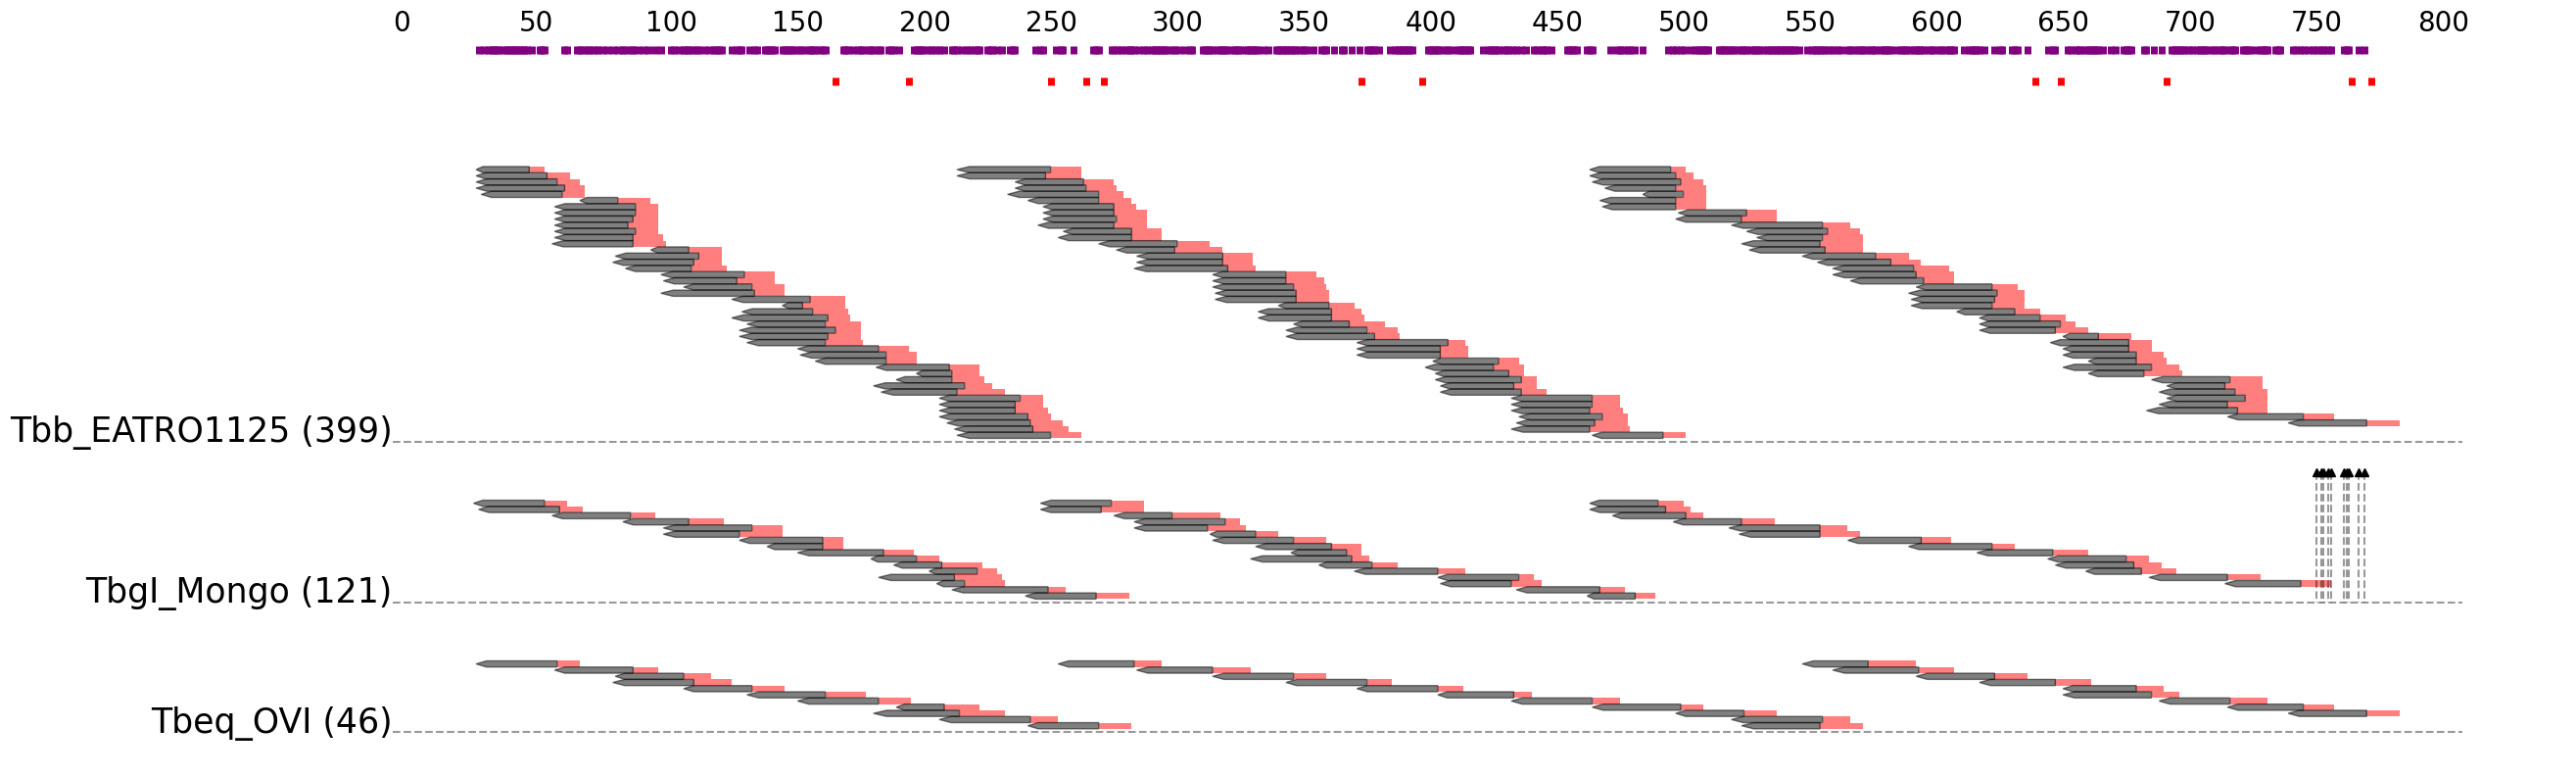

In [30]:
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_Mongo','Tbeq_OVI',]},
                   combined,'A6_v1',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

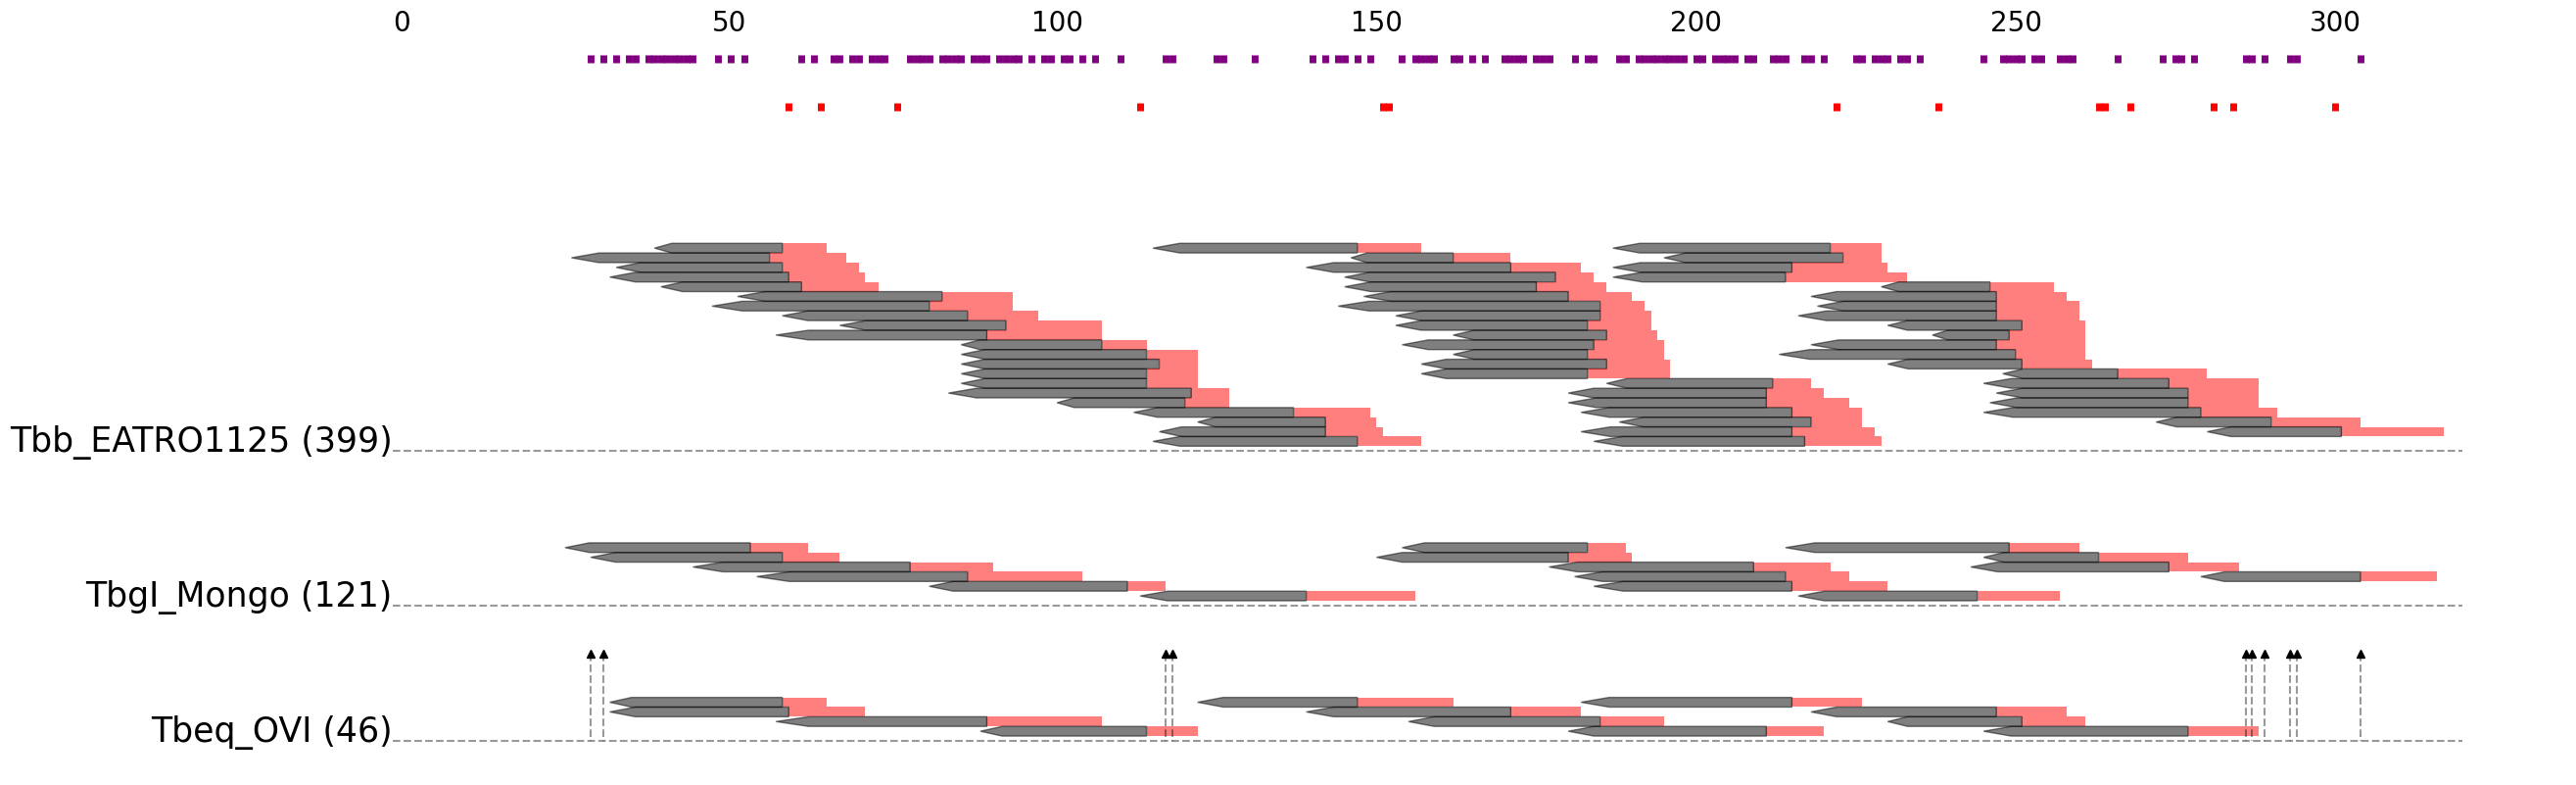

In [16]:
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_Mongo','Tbeq_OVI',]},
                   combined,'RPS12',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

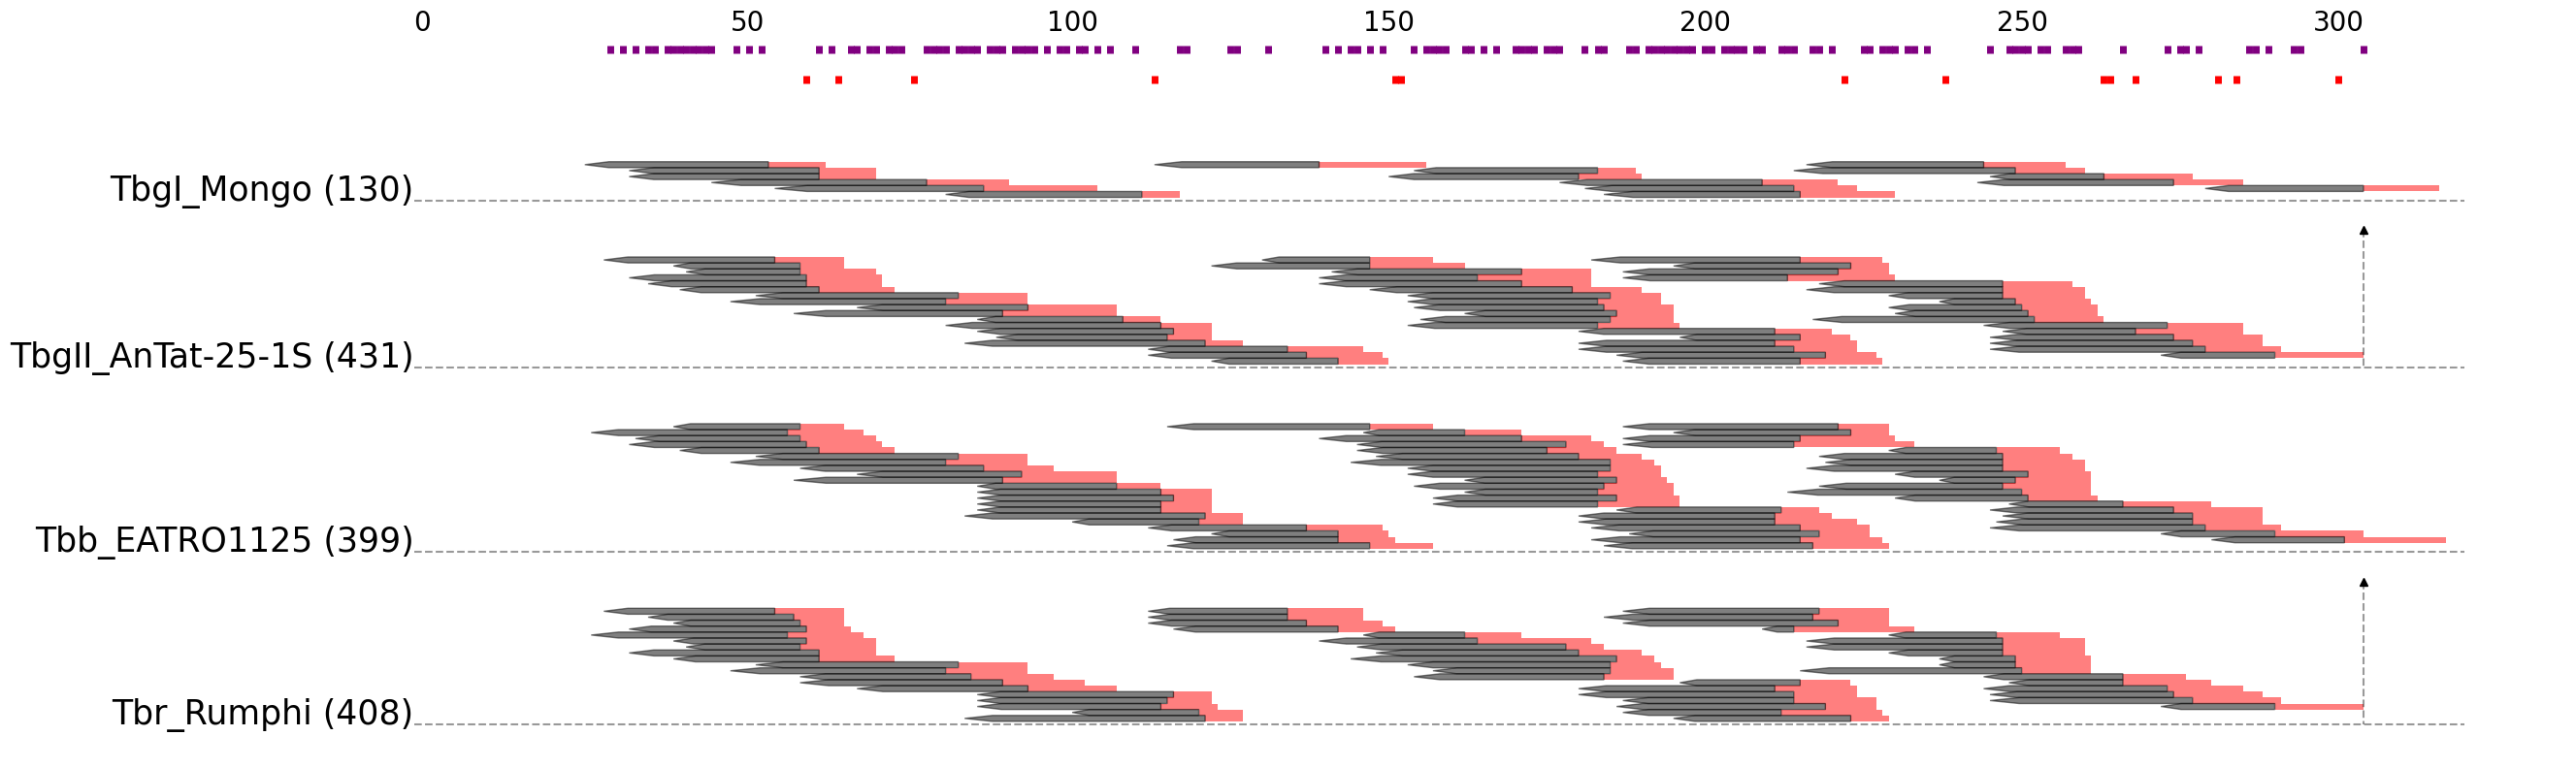

In [16]:
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_Mongo','TbgII_AnTat-25-1S','Tbb_EATRO1125','Tbr_Rumphi']},
                   combined,'RPS12',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbr_Etat-1-2R','Tbr_AnTat-25-1S','Tbr_Rumphi','Tbr_MHOM-UG-77-KETRI-2355','Tbr_STIB847','Tbr_STIB-851','Tbr_STIB883','Tbr_STIB882']},
                   combined,'ND7',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids

nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F','Tbb_MBO-NG-74-R10-bis',
                                               'Tbb_MBO-NG-74-R10','Tbb_Lister-427-AT1-KO','Tbb_Lister-427']},
                   combined,'A6_v2',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F',
                                               'Tbb_Lister-427-AT1-KO','Tbb_MBO-NG-74-R10-bis',
                                               'Tbb_MBO-NG-74-R10','Tbb_Lister-427']},
                   combined,'RPS12',outdir,
                     y=-3.3,fold=3,figw=20,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F',
                                               'Tbb_Lister-427-AT1-KO','Tbb_MBO-NG-74-R10-bis',
                                               'Tbb_MBO-NG-74-R10','Tbb_Lister-427']},
                   combined,'COX3',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F',
                                               'Tbb_Lister-427-AT1-KO','Tbb_Lister-427',
                                               'Tbb_MBO-NG-74-R10-bis','Tbb_MBO-NG-74-R10']},
                   combined,'CR3',outdir,
                     y=-3.3,fold=3,figw=30,figh=20,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F','Tb_P16F','Tb_MSUS-CI-82-TSW95',
                                               'Tbb_Lister-427-AT1-KO','Tbb_Lister-427',
                                               'Tbb_MBO-NG-74-R10-bis','Tbb_MBO-NG-74-R10']},
                   combined,'ND3',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F','Tb_P16F','Tb_MSUS-CI-82-TSW95',
                                               'Tbb_Lister-427-AT1-KO','Tbb_Lister-427',
                                               'Tbb_MBO-NG-74-R10-bis','Tbb_MBO-NG-74-R10']},
                   combined,'ND7',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F','Tb_P16F','Tb_MSUS-CI-82-TSW95',
                                               'Tbb_Lister-427-AT1-KO','Tbb_Lister-427',
                                               'Tbb_MBO-NG-74-R10-bis','Tbb_MBO-NG-74-R10']},
                   combined,'ND8_v1',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F','Tbb_MBO-NG-74-R10-bis','Tbb_MBO-NG-74-R10','Tbb_Lister-427-AT1-KO','Tbb_Lister-427']},combined,'ND9',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_104AT','TbgI_LiTat-1-3','Tbeq_OVI']},combined,'A6_v2',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_104AT','TbgI_LiTat-1-3','Tbeq_OVI']},
                   combined,'COX3',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

In [ ]:
#plot parental strains and two hybrids
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
nd9=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_104AT','TbgI_LiTat-1-3','Tbeq_OVI']},
                   combined,'RPS12',outdir,
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')